# 数据管道DataSet

对于小数据集直接读入内存，效率高；

对于大数据集，无法一次性读入内存，通常需要在训练的过程中分批次读取；

使用tf.DataSet　API可以方便构建输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
import pandas as pd
from matplotlib import pyplot as plt

## 一．构建数据管道

可以从numpy.array,pandas,generator,csv,txt,文件路径，tfrecords文件等方式构建数据管道．

其中通过Numpy array,Pandas DataFrame ，文件路径构造是数据管道最常用的方法．

通过tfrecoreds文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecoreds文件，读取后在解析成tf.Example.

但tfrecoreds文件的优点是压缩后文件较小，便于网络传输，加载速度较快．

### 1.从numpy数组创建数据管道

In [2]:
iris = datasets.load_iris()

ds1 = tf.data.Dataset.from_tensor_slices((iris['data'],iris['target']))
for features,label in ds1.take(5):
    print(features,label)

tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.7 3.2 1.3 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([5.  3.6 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


### 2.从pandas DataFrame构建数据管道

In [3]:
dfiris = pd.DataFrame(iris['data'],columns=iris.feature_names)
ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict('list'),iris['target']))
for features,label in ds2.take(5):
    print(features,label)

{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.7>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.2>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.3>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float

### 3.从Python　generator构建数据管道

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
##　定义一个从文件中读取图片的generator
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    './../data/cifar2/test/',
    target_size=(32,32),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [5]:
classdict = image_generator.class_indices
print(classdict)

{'airplane': 0, 'automobile': 1}


In [6]:
def generator():
    for features,label in image_generator:
        yield (features,label)
        
ds3 = tf.data.Dataset.from_generator(generator=generator,output_types=(tf.float32,tf.int32))

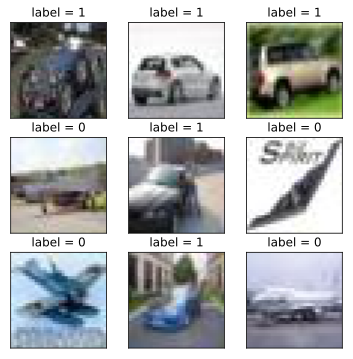

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6))
for i,(img,label) in enumerate(ds3.unbatch().take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title('label = %d'%(label))
    ax.set_xticks([]) ## 设置
    ax.set_yticks([])
plt.show()

### 4.从csv文件构建数据管道

In [8]:
ds4 = tf.data.experimental.make_csv_dataset(
    file_pattern = ['./../data/titanic/train.csv','./../data/titanic/test.csv'],
    batch_size=3,
    label_name='Survived',
    na_value='',
    num_epochs=1,
    ignore_errors=True
)
for data,labels in ds4.take(2):
    print(data,labels)

OrderedDict([('PassengerId', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([880,  13, 111], dtype=int32)>), ('Pclass', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 3, 1], dtype=int32)>), ('Name', <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)',
       b'Saundercock, Mr. William Henry',
       b'Porter, Mr. Walter Chamberlain'], dtype=object)>), ('Sex', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'female', b'male', b'male'], dtype=object)>), ('Age', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([56., 20., 47.], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>), ('Parch', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 0, 0], dtype=int32)>), ('Ticket', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'11767', b'A/5. 2151', b'110465'], dtype=object)>), ('Fare', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([83.1583,  8.05  , 52.    ], dtype=float32

### 5.从文本文件构建数据管道

In [9]:
ds5 = tf.data.TextLineDataset(filenames=['./../data/titanic/train.csv','./../data/titanic/test.csv']).skip(1) ## 略去首行
for line in ds5.take(5):
    print(line)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,,S', shape=(), dtype=string)


### 6.从文件路径构建数据管道

In [10]:
ds6 = tf.data.Dataset.list_files('./../data/cifar2/train/*/*.jpg')
for file in ds6.take(5):
    print(file)

tf.Tensor(b'./../data/cifar2/train/automobile/4632.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/airplane/4517.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/airplane/1736.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/automobile/3946.jpg', shape=(), dtype=string)
tf.Tensor(b'./../data/cifar2/train/airplane/1092.jpg', shape=(), dtype=string)


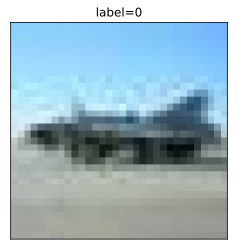

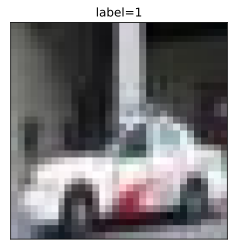

In [11]:
def load_image(img_path,size=(32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,'.*/automobile/.*') else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)
    return (img,label)
for i, (img,label) in enumerate(ds6.map(load_image).take(2)):
    plt.figure(i)
    plt.imshow((img/255.).numpy())
    plt.title('label=%d'%label)
    plt.xticks([])
    plt.yticks([])

### 7.从tfrecords文件构建数据管道

通过tfrecoreds文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecoreds文件，读取后在解析成tf.Example.

In [12]:
import os
def create_tfrecords(inpath,outpath):
    '''
    inpath:原始文件路径
    outpath:TFRecord文件输出路径
    '''
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index,name in enumerate(dirs):
        class_path = os.path.join(inpath,name)
        for image_name in os.listdir(class_path):
            img_path = os.path.join(class_path,image_name)
            img = tf.io.read_file(img_path)
            
            example = tf.train.Example(
                features = tf.train.Features(feature={
                    'label':tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
                    'img_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.numpy()]))
                })
            )
            writer.write(example.SerializeToString())
    writer.close()
create_tfrecords('./../data/cifar2/test/','./../data/cifar2_test1.tfrecords/')

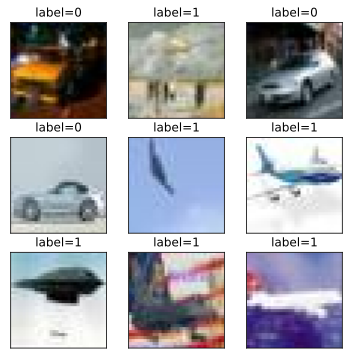

In [13]:
def parse_example(proto):
    desc = {'img_raw': tf.io.FixedLenFeature([],tf.string),'label':tf.io.FixedLenFeature([],tf.int64)}
    example = tf.io.parse_single_example(proto,desc)
    img = tf.image.decode_jpeg(example['img_raw'])
    img = tf.image.resize(img,(32,32))
    label = example['label']
    return (img,label)

ds7 = tf.data.TFRecordDataset('./../data/cifar2_test1.tfrecords').map(parse_example).shuffle(3000)
plt.figure(figsize=(6,6))
for i,(img,label) in enumerate(ds7.take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow((img/255.).numpy())
    ax.set_title('label=%d'%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 二．数据转换

Dataset数据结构应用非常灵活，因为它本质上是一个Sequece序列，其每个元素可以是各种类型，例如可以是张量，列表，字典，也可以是Dataset。

Dataset包含了非常丰富的数据转换功能。

- map: 将转换函数映射到数据集每一个元素。
- flat_map: 将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。
- interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。
- filter: 过滤掉某些元素。
- zip: 将两个长度相同的Dataset横向铰合。
- concatenate: 将两个Dataset纵向连接。
- reduce: 执行归并操作。
- batch : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。
- padded_batch: 构建批次，类似batch, 但可以填充到相同的形状。
- window :构建滑动窗口，返回Dataset of Dataset.
- shuffle: 数据顺序洗牌。
- repeat: 重复数据若干次，不带参数时，重复无数次。
- shard: 采样，从某个位置开始隔固定距离采样一个元素。
- take: 采样，从开始位置取前几个元素。

In [21]:
ds = tf.data.Dataset.from_tensor_slices(['hello world','hello china','hello Beijing'])

In [16]:
## map,flat_map,interleave
ds_map = ds.map(lambda x:tf.strings.split(x,' '))
for x in ds_map:
    print(x)
    
print('-'*10)
ds_flat_map = ds.flat_map(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x,' '))) ## 将嵌套的DataSet压平
for x in ds_flat_map:
    print(x)

print('-'*10)
ds_interleavle = ds.interleave(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x,' '))) ## 将不同来源数据集夹在一起（纵向）
for x in ds_interleavle:
    print(x)

tf.Tensor([b'hello' b'world'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'china'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'Beijing'], shape=(2,), dtype=string)
----------
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'china', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)
----------
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'china', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [35]:
## filter,reduce,take, shard

ds_filter = ds.filter(lambda x:tf.strings.regex_full_match(x,'.*[a|B].*'))
for x in ds_filter:
    print(x)
print('-'*10)

ds1 = tf.data.Dataset.from_tensor_slices([1,2,3,4,5.0])
result = ds1.reduce(0.0,lambda x,y:tf.add(x,y))
print(result)
print('-'*10)

ds_take = ds1.take(3)
print(list(ds_take.as_numpy_iterator()))
print('-'*10)

#从第一个位置开始，每隔２个元素采样一次
ds_shard = ds1.shard(2,index=1)
for x in ds_shard:
    print(x)

tf.Tensor(b'hello china', shape=(), dtype=string)
tf.Tensor(b'hello Beijing', shape=(), dtype=string)
----------
tf.Tensor(15.0, shape=(), dtype=float32)
----------
[1.0, 2.0, 3.0]
----------
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


In [32]:
## zip,concatenate　均是把ds看做为列向量
ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds3 = tf.data.Dataset.range(6,9)
ds_zip = tf.data.Dataset.zip((ds1,ds2,ds3)) ## 横向拼接
for x,y,z in ds_zip:
    print(x.numpy(),y.numpy(),z.numpy())
print('-'*10)
ds_concat = tf.data.Dataset.concatenate(ds1,ds2)
for x in ds_concat:
    print(x)

0 3 6
1 4 7
2 5 8
----------
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [34]:
## batch,padded_batch 
ds4 = tf.data.Dataset.range(13)
ds_batch = ds4.batch(4)##不会填充０补齐
for x in ds_batch:
    print(x)
print('-'*10)
elements = [[1,2],[3,4,5],[6,7],[8]]
ds5 = tf.data.Dataset.from_generator(lambda :iter(elements),output_types=tf.int32)
ds_padder_batch = ds5.padded_batch(2,padded_shapes=[5,])
for x in ds_padder_batch:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)
tf.Tensor([12], shape=(1,), dtype=int64)
----------
tf.Tensor(
[[1 2 0 0 0]
 [3 4 5 0 0]], shape=(2, 5), dtype=int32)
tf.Tensor(
[[6 7 0 0 0]
 [8 0 0 0 0]], shape=(2, 5), dtype=int32)


In [47]:
## window:构建滑动窗口，返回的是DataSet of DataSet,使用flatmap压平
ds6 = tf.data.Dataset.range(6)
ds_window = ds6.window(3,shift=1).flat_map(lambda x:x.batch(3,drop_remainder=True))
for x in ds_window:
    print(x)
print('*'*10)
ds_window = ds6.window(3,shift=1).flat_map(lambda x:x.take(5))
for x in ds_window:
    print(x)

tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
**********
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [72]:
## shuffle,repeat
ds_shuffle = ds6.shuffle(buffer_size=2)
for x in ds_shuffle:
    print(x)
print('*'*10)
ds_repeat = tf.data.Dataset.range(3).repeat(4)
for x in ds_repeat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
**********
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


补充shuffle和repeat原理:

- 首先，DataSet会先取所有数据的前buffer_size个数据项，填充到buffer．
- 此时，随机从buffer中选择一条数据项，对应buffer的位置也就空出来了，此时从原来数据集中按照原来的顺序选择最新的一条数据填充到buffer中．
- 最后从buffer中随机选择下一条数据输出(到batch中).
- 注意：
    - 如果buffer size = 1,代表不会打乱数据集，如果buffer size = len(data) 代表随机打乱原数据集．
    - 如果设置了batch size，则一条数据项中包含了batch size 条真实的数据．

- 而repeat就是epoch的意思．

- 正常使用顺序为:shuffle() batch() repeat()
- 官网推荐顺序：repeat() shuffle() batch()　这样就模糊了样本的epoch关系，相当于直接对样本重复N次处理．

### 三．提升管道性能

模型训练会非常的耗时，主要来自于数据准备和参数迭代，参数迭代的过程耗时通常依赖于GPU提升．

而数据准备的过程则可以通过构建有效的数据管道进行提升．

以下建议：

- 1.使用prefetch方法可以让数据和参数迭代的两个过程并行起来．
- 2.使用interleave可以让数据读取的过程多进程进行，并将不同来源数据合并在一起．
- 3.使用map设置num_parallel_calls可以让数据转换过程多进程执行.
- 4.使用cache方法可以让数据在第一个epoch后缓存在内存中，仅限于数据集不大的场景.
- 5.使用map转换时，先进行batch操作，然后采样向量化的转换方法对每个batch进行转换.

In [50]:
##针对１
@tf.function
def printbar():
    '''打印时间分割线'''
    ts = tf.timestamp()
    today_ts = ts%(24*60*60)
    
    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minute = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format('{}',m)) == 1:
            return (tf.strings.format('0{}',m))
        else:
            return (tf.strings.format('{}',m))
    timestring = tf.strings.join([timeformat(hour),timeformat(minute),timeformat(second)],separator=':')
    tf.print('==========='*8,end='')
    tf.print(timestring)

In [51]:
import time
## 数据准备和参数迭代的过程默认是串行进行的
# 模拟数据准备过程
def generator():
    for i in range(10):
        ## 假设每次数据准备需要２s
        time.sleep(2)
        yield i
ds = tf.data.Dataset.from_generator(generator,output_types=tf.int32)
## 模拟参数迭代
def train_step():
    ## 假设每次迭代训练需要1s
    time.sleep(1)

In [52]:
printbar()
tf.print(tf.constant('start training...'))
for x in ds:
    train_step()
printbar()
tf.print(tf.constant('end trainging'))

========================================================================================20:30:47
start training...
========================================================================================20:31:17
end trainging


以上说明是串行的，需要的时间是20 + 10

In [54]:
printbar()
tf.print(tf.constant('start training...'))
for x in ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE): ## 可以让程序自动选择合适的参数
    train_step()
printbar()
tf.print(tf.constant('end trainging'))

========================================================================================20:33:06
start training...
========================================================================================20:33:27
end trainging


以上说明是并行的，需要的时间是max(20,10)

In [55]:
## 针对２
ds_files = tf.data.Dataset.list_files('./../data/titanic/*.csv')

In [57]:
ds1 = ds_files.flat_map(lambda x:tf.data.TextLineDataset(x).skip(1))
for x in ds1.take(2):
    print(x)
print('*'*10)
ds2 = ds_files.interleave(lambda x:tf.data.TextLineDataset(x).skip(1))
for x in ds2.take(2):
    print(x)

tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
**********
tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)


In [58]:
##　针对３
ds = tf.data.Dataset.list_files('./../data/cifar2/train/*/*.jpg')
def load_image(img_path,size=(32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,'.*/automobile/.*') else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)
    return (img,label)

In [63]:
## 单线程
printbar()
tf.print(tf.constant('start training...'))
ds_map = ds.map(load_image)
for _ in ds_map:
    pass
printbar()
tf.print(tf.constant('end training...'))

========================================================================================20:47:03
start training...
========================================================================================20:47:05
end training...


In [64]:
## 多线程
printbar()
tf.print(tf.constant('start training...'))
ds_map = ds.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
for _ in ds_map:
    pass
printbar()
tf.print(tf.constant('end training...'))

========================================================================================20:47:27
start training...
========================================================================================20:47:28
end training...


In [65]:
#针对４
ds = tf.data.Dataset.from_generator(generator,output_types=tf.int32)
##　no cache
printbar()
tf.print(tf.constant('start training...'))
for epoch in tf.range(3):
    for x in ds:
        train_step()
    printbar()
    tf.print('epoch=%d, ended'%(epoch))
printbar()
tf.print(tf.constant('end training'))
## (10*2+10)*3=90

========================================================================================20:54:22
start training...
========================================================================================20:54:52
epoch=0, ended
========================================================================================20:55:22
epoch=1, ended
========================================================================================20:55:52
epoch=2, ended
========================================================================================20:55:52
end training


In [66]:
ds = tf.data.Dataset.from_generator(generator,output_types=tf.int32).cache()
##　no cache
printbar()
tf.print(tf.constant('start training...'))
for epoch in tf.range(3):
    for x in ds:
        train_step()
    printbar()
    tf.print('epoch=%d, ended'%(epoch))
printbar()
tf.print(tf.constant('end training'))
##(10*2+10) + (10)*2 = 50

========================================================================================20:57:20
start training...
========================================================================================20:57:50
epoch=0, ended
========================================================================================20:58:00
epoch=1, ended
========================================================================================20:58:10
epoch=2, ended
========================================================================================20:58:10
end training


In [67]:
## 针对5
ds = tf.data.Dataset.range(100000)

In [68]:
ds_map_batch = ds.map(lambda x:x**2).batch(20)
printbar()
tf.print(tf.constant('start training...'))
for x in ds_map_batch:
    pass
printbar()
tf.print(tf.constant('end training'))

========================================================================================21:01:41
start training...
========================================================================================21:01:43
end training


In [70]:
ds_map_batch = ds.batch(20).map(lambda x:x**2)
printbar()
tf.print(tf.constant('start training...'))
for x in ds_map_batch:
    pass
printbar()
tf.print(tf.constant('end training'))

========================================================================================21:02:04
start training...
========================================================================================21:02:04
end training
